In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
%matplotlib inline
pd.options.display.float_format = '{:20,.4f}'.format
np.set_printoptions(suppress=True)

import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

## 1. read data, data overview

In [48]:
df = pd.read_csv('train.csv')
df = df.set_index('id',drop=True)
#df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')
df.drop_duplicates(inplace=True)
display(df.head())
#display(df.tail())
#display(df.describe())
print(df.shape)
#print(df.dtypes)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0000,4.0000,nan,nan,nan,nan,nan,nan,...,9.0000,4.0000,0.0000,13.0000,22.0000,1.0000,0.0000,52.0000,4.0000,"5,850,000.0000"
2,2011-08-23,34,19.0000,3.0000,nan,nan,nan,nan,nan,nan,...,15.0000,3.0000,0.0000,15.0000,29.0000,1.0000,10.0000,66.0000,14.0000,"6,000,000.0000"
3,2011-08-27,43,29.0000,2.0000,nan,nan,nan,nan,nan,nan,...,10.0000,3.0000,0.0000,11.0000,27.0000,0.0000,4.0000,67.0000,10.0000,"5,700,000.0000"
4,2011-09-01,89,50.0000,9.0000,nan,nan,nan,nan,nan,nan,...,11.0000,2.0000,1.0000,4.0000,4.0000,0.0000,0.0000,26.0000,3.0000,"13,100,000.0000"
5,2011-09-05,77,77.0000,4.0000,nan,nan,nan,nan,nan,nan,...,319.0000,108.0000,17.0000,135.0000,236.0000,2.0000,91.0000,195.0000,14.0000,"16,331,452.0000"


(30101, 291)


## 2. Treat outliers as missing values

In [49]:
# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(len(numeric_cols))

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
df_non_numeric = df_non_numeric.apply(lambda col:col.str.lower(),axis=0)
non_numeric_cols = df_non_numeric.columns.values
print(len(non_numeric_cols))

275
16


In [50]:
# numerical columns
zscore = (df_numeric-df_numeric.mean())/df_numeric.std()
zscore.describe()
zscore = zscore[abs(zscore)<2]
df_numeric = df_numeric + zscore*0

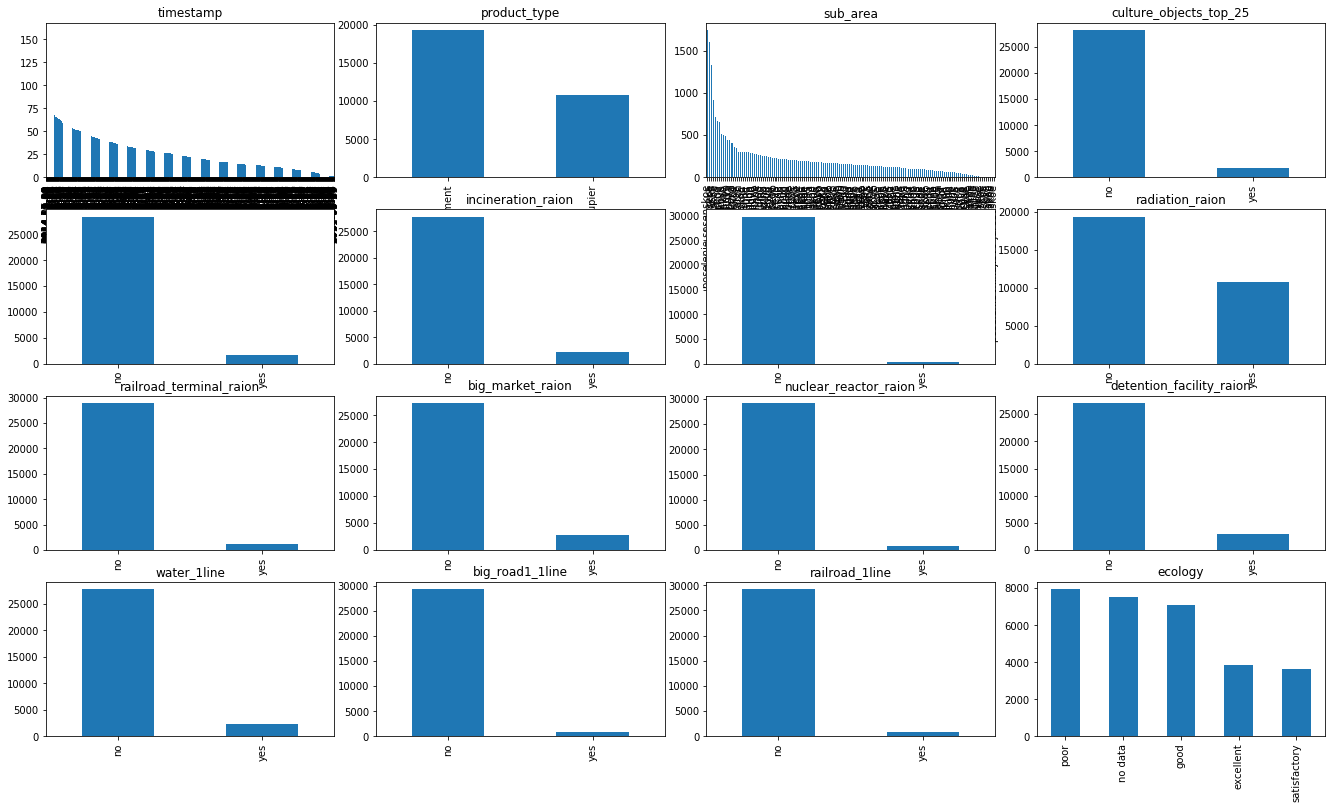

In [51]:
# non_numeric columns
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
k = 0
for i in range(4):
    for j in range(4):
        col = non_numeric_cols[k]
        df_non_numeric[col].value_counts().plot.bar(ax = axs[i,j],title=col)
        k = k + 1
plt.show()

In [52]:
# check specific non-numerical columns
unique_time = df_non_numeric['timestamp'].unique()
display(unique_time)
unique_area = df_non_numeric['sub_area'].unique()
display(unique_area)

array(['2011-08-20', '2011-08-23', '2011-08-27', ..., '2015-06-01',
       '2015-06-02', '2015-06-03'], dtype=object)

array(['bibirevo', 'nagatinskij zaton', "tekstil'shhiki", 'mitino',
       'basmannoe', 'nizhegorodskoe', "sokol'niki", 'koptevo', 'kuncevo',
       'kosino-uhtomskoe', 'zapadnoe degunino', 'presnenskoe',
       'lefortovo', "mar'ino", "kuz'minki", 'nagornoe', "gol'janovo",
       'vnukovo', 'juzhnoe tushino', 'severnoe tushino',
       "chertanovo central'noe", 'fili davydkovo', 'otradnoe',
       'novo-peredelkino', 'bogorodskoe', 'jaroslavskoe', 'strogino',
       'hovrino', "moskvorech'e-saburovo", 'staroe krjukovo', 'ljublino',
       'caricyno', 'veshnjaki', 'danilovskoe', 'preobrazhenskoe',
       "kon'kovo", 'brateevo', 'vostochnoe izmajlovo', 'vyhino-zhulebino',
       'donskoe', 'novogireevo', 'juzhnoe butovo', 'sokol', 'kurkino',
       'izmajlovo', 'severnoe medvedkovo', 'rostokino',
       'orehovo-borisovo severnoe', 'ochakovo-matveevskoe', 'taganskoe',
       'dmitrovskoe', 'orehovo-borisovo juzhnoe', 'teplyj stan',
       'babushkinskoe', 'pokrovskoe streshnevo', 'obruc

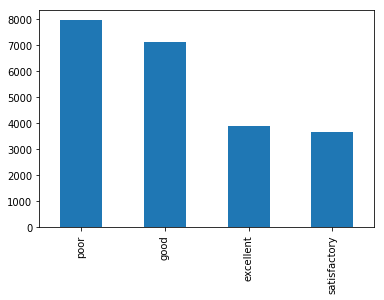

In [53]:
# action on non-numerical columns
df_non_numeric['ecology'] = df_non_numeric['ecology'].replace('no data',np.nan)
df_non_numeric['ecology'].value_counts().plot.bar()

In [54]:
df_clean = pd.concat([df_numeric,df_non_numeric],axis=1)
df_clean = df_clean[df.columns]
df_clean.shape

(30101, 291)

## 2. remove missing values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000009F85B3C518>]],
      dtype=object)

(28361, 291)


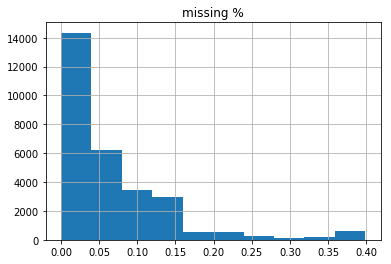

In [55]:
#remove observations with missing data
## house_price has to have value
df_clean = df_clean[df_clean['price_doc'].notna()]
## observation with 'majority of the features' unavailable needs to be dropped
missing_percent_row = pd.DataFrame(((df_clean.isnull().sum(axis=1))/(df_clean.shape[1])),columns = ['missing %'])
display(missing_percent_row.hist())
threshold = (df_clean.shape[1])*0.7 #at least % data available
df_clean = df_clean.dropna(thresh=threshold,axis=0)
print(df_clean.shape)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000009F85B391D0>]],
      dtype=object)

Index(['max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state',
       'hospital_beds_raion', 'cafe_sum_500_min_price_avg',
       'cafe_sum_500_max_price_avg', 'cafe_avg_price_500'],
      dtype='object')


(28361, 281)

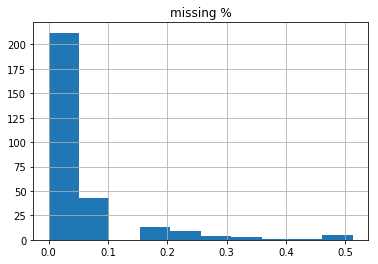

In [56]:
# remove features with missing data
missing_percent_column = pd.DataFrame(((df_clean.isnull().sum())/(df_clean.shape[0])),columns = ['missing %'])
display(missing_percent_column.hist())
print(missing_percent_column[missing_percent_column['missing %']>0.3].index)
threshold = len(df_clean)*0.7 #at least % data available
df_clean = df_clean.dropna(thresh=threshold,axis=1)
df_clean.shape

## 3. separate numeric and non-numeric columns

In [57]:
# select numeric columns
df_numeric = df_clean.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(len(numeric_cols))

# select non numeric columns
df_non_numeric = df_clean.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(len(non_numeric_cols))

265
16


## 4. fill missing values

In [58]:
df_numeric = df_numeric.fillna(df_numeric.median())
df_non_numeric = df_non_numeric.apply(lambda col:col.fillna(col.mode()[0]),axis=0)
df_train = pd.concat([df_numeric,df_non_numeric],axis=1)
df_train = df_train.drop_duplicates()
df_train.shape

(28354, 281)

In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28354 entries, 1 to 30112
Columns: 281 entries, full_sq to ecology
dtypes: float64(265), object(16)
memory usage: 61.0+ MB


## 5. normalize data

In [60]:
## label encoding for large categorical data or only two choices
lbl = preprocessing.LabelEncoder()
df_train['sub_area'] = lbl.fit_transform(list(df_train['sub_area'].values))
## one hot encoder to categorical data
col_list = list(df_train.columns)
for c in col_list[1:]:
    if df_train[c].dtype=='object' and c!='timestamp':
        dum_df = pd.get_dummies(df_train[c], columns=[c],prefix=c)
        df_train = df_train.drop([c],axis=1).join(dum_df)
display(df_train.shape)

(28354, 297)

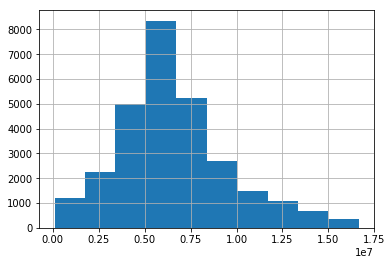

In [61]:
# check if need to use log price
df_train['price_doc'].hist()

In [62]:
df_train['log_price'] = np.log(df['price_doc'])

In [63]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'], format='%Y-%m-%d')
df_train['year']=pd.DatetimeIndex(df_train['timestamp']).year
df_train['month']=pd.DatetimeIndex(df_train['timestamp']).month
df_train['day']=pd.DatetimeIndex(df_train['timestamp']).day
df_train = df_train.drop(['timestamp'],axis=1)

In [64]:
train = df_train.iloc[:-50,:]
test = df_train.iloc[-50:,:]
x_train = train.drop(['price_doc','log_price'],axis=1)
y_train = train['log_price']
x_test = test.drop(['price_doc','log_price'],axis=1)
y_test = test['log_price']

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler2 = StandardScaler()

x_train_s = scaler.fit_transform(x_train)
x_train_s = pd.DataFrame(x_train_s,columns=x_train.columns)
# y_train_s = scaler2.fit_transform(y_train.reshape(-1,1)) ### python version difference
y_train_s = scaler2.fit_transform(pd.DataFrame(y_train))

x_test_s = scaler.transform(x_test)
x_test_s = pd.DataFrame(x_test_s,columns=x_test.columns)
# y_train_s = scaler2.fit_transform(y_train.reshape(-1,1)) ### python version difference
y_test_s = scaler2.transform(pd.DataFrame(y_test))

## 6.1 standard linear regression - run regression

In [66]:
import statsmodels.api as sm
x2_train_s = sm.add_constant(x_train_s)
ols = sm.OLS(y_train_s,x2_train_s)
result = ols.fit()
beta = result.params
fitted_s = np.dot(x2_train_s,beta)
res_s = y_train_s - fitted_s
pvalues = result.pvalues
r2 = result.rsquared
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     44.39
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:54:17   Log-Likelihood:                -35076.
No. Observations:               28304   AIC:                         7.070e+04
Df Residuals:                   28030   BIC:                         7.296e+04
Df Model:                         273                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [67]:
df_linear = df_train.copy()
df_linear = df_linear.iloc[:-50,:]

In [68]:
fitted = scaler2.inverse_transform(fitted_s)
df_linear['fitted'] = np.exp(fitted)
df_linear['res'] = df_linear['price_doc'] - df_linear['fitted']

## 6.2 standard linear regression - check predictive power

In [69]:
#x_test_s.insert(0,'const',1)
#x2_test_s = x_test_s
forecast_s = np.dot(x_test_s,beta[1:])+beta[0]
log_forecast = scaler2.inverse_transform(forecast_s)
forecast = np.exp(log_forecast)
df_train['log_forecast']=df_train['log_price']
df_train['log_forecast'][-50:] = log_forecast 
df_train['forecast']=df_train['price_doc']
df_train['forecast'][-50:] = forecast
df_train.tail()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,full_sq,life_sq,floor,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,...,ecology_excellent,ecology_good,ecology_poor,ecology_satisfactory,log_price,year,month,day,log_forecast,forecast
id,,,,,,,,,,,,,,,,,,,,,
30108,53.0000,1.0000,1.0000,"35,747,947.9100","2,546.0000",0.5490,0.0347,175.0000,"2,854.0000",0.0000,...,0,0,1,0,15.2507,2015,6,3,15.1333,"3,735,108.8677"
30109,64.0000,30.0000,5.0000,"25,536,296.8100","4,001.0000",0.4963,0.0071,275.0000,"2,854.0000",0.0000,...,0,0,1,0,15.9887,2015,6,3,15.7762,"7,104,094.5276"
30110,46.0000,46.0000,4.0000,"40,366,999.5100","21,819.0000",0.4928,0.0758,"1,497.0000","2,854.0000",0.0000,...,0,0,1,0,15.5794,2015,6,3,15.5672,"5,764,291.6069"
30111,54.0000,28.0000,12.0000,"8,392,316.2100","130,396.0000",0.4264,0.0022,"6,980.0000","4,523.0000",5.0000,...,0,0,0,1,16.0668,2015,6,3,15.8339,"7,526,140.7728"
30112,83.0000,30.0000,16.0000,"25,536,296.8100","4,001.0000",0.4963,0.0071,275.0000,"2,854.0000",0.0000,...,0,0,1,0,16.1737,2015,6,3,16.1101,"9,919,902.1321"


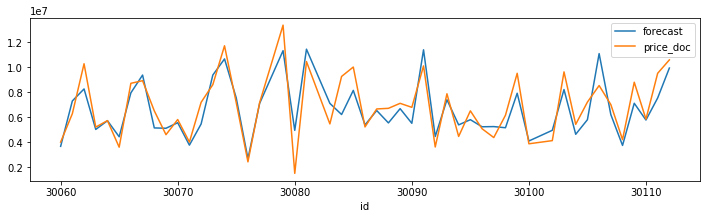

In [70]:
df_train[['forecast','price_doc']][-50:].plot(figsize=(12,3))

##### Dudu Amendments

In [85]:
def getRSquare(pred_y, real_y):
    temp = pd.DataFrame(pred_y, columns = ['Predicted Y'])
    temp['Real Y'] = real_y
    return temp['Predicted Y'].corr(temp['Real Y'])**2

x2_test_s = sm.add_constant(x_test_s)
pred_y = result.predict(x2_test_s)
'Out of Sample R-square', getRSquare(pred_y, y_test_s)

## 6.3 linear regression - try cross validation

In [26]:
lm = LinearRegression()
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm,x_train_s, y_train_s, scoring='neg_mean_squared_error', cv=folds)
print(np.mean(scores))

-0.7294640775674421


##### Dudu Amendment

In [44]:
pipeline = Pipeline([('Transform', StandardScaler()), ('Classifier', LinearRegression())])
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

cv_score = cross_val_score(pipeline, df_train.drop(['price_doc','log_price'],axis=1), df_train['log_price'], cv=folds,
                           scoring='neg_mean_squared_error')
cv_score.mean()

-9.202056960597407e-05

## 7.1 lasso regression - run regression

In [27]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.05,fit_intercept=True,random_state=1000)
lasso.fit(x_train_s, y_train_s)

beta = lasso.coef_         # dense np.array
intercept = lasso.intercept_    # probably also relevant
r2 = lasso.score(x_train_s, y_train_s)

In [28]:
beta_df = pd.DataFrame(beta).T
beta_df.columns=x_train_s.columns
beta_df = beta_df.T
beta_df_important = beta_df[beta_df[0]!=0]
beta_df_important = beta_df_important.T
beta_df_important.T

,0
full_sq,0.3579
school_education_centers_raion,0.0265
sport_objects_raion,0.0081
shopping_centers_raion,0.0168
metro_min_walk,-0.0725
kremlin_km,-0.0132
nuclear_reactor_km,-0.0042
big_church_km,-0.0164
catering_km,-0.0063
cafe_count_500,0.0009


## 7.2 lasso regression - check predictive power

In [29]:
forecast_s = np.dot(x_test_s,beta)+intercept
log_forecast = scaler2.inverse_transform(forecast_s)
forecast = np.exp(log_forecast)
df_train['log_forecast']=df_train['log_price']
df_train['log_forecast'][-50:] = log_forecast 
df_train['forecast']=df_train['price_doc']
df_train['forecast'][-50:] = forecast
df_train.tail()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,full_sq,life_sq,floor,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,...,ecology_excellent,ecology_good,ecology_poor,ecology_satisfactory,log_price,year,month,day,log_forecast,forecast
id,,,,,,,,,,,,,,,,,,,,,
30108,53.0000,1.0000,1.0000,"35,747,947.9100","2,546.0000",0.5490,0.0347,175.0000,"2,854.0000",0.0000,...,0,0,1,0,15.2507,2015,6,3,15.3061,"4,439,557.4865"
30109,64.0000,30.0000,5.0000,"25,536,296.8100","4,001.0000",0.4963,0.0071,275.0000,"2,854.0000",0.0000,...,0,0,1,0,15.9887,2015,6,3,15.7048,"6,614,850.5154"
30110,46.0000,46.0000,4.0000,"40,366,999.5100","21,819.0000",0.4928,0.0758,"1,497.0000","2,854.0000",0.0000,...,0,0,1,0,15.5794,2015,6,3,15.5415,"5,618,101.4570"
30111,54.0000,28.0000,12.0000,"8,392,316.2100","130,396.0000",0.4264,0.0022,"6,980.0000","4,523.0000",5.0000,...,0,0,0,1,16.0668,2015,6,3,15.7324,"6,799,631.6425"
30112,83.0000,30.0000,16.0000,"25,536,296.8100","4,001.0000",0.4963,0.0071,275.0000,"2,854.0000",0.0000,...,0,0,1,0,16.1737,2015,6,3,15.9276,"8,265,687.5022"


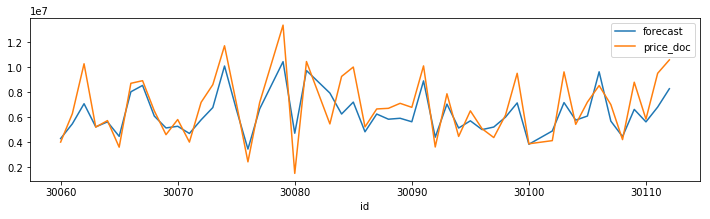

In [30]:
df_train[['forecast','price_doc']][-50:].plot(figsize=(12,3))

## (Dudu Amendment) 7.25 Lasso Cross Validation

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

lasso = Lasso(alpha=0.05,fit_intercept=True,random_state=1000)

pipeline = Pipeline([('Transform', StandardScaler()), ('Classifier', lasso)])

cv_score = cross_val_score(pipeline, df_train.drop(['price_doc','log_price'],axis=1), df_train['log_price'], cv=5,
                           scoring='neg_mean_squared_error')

cv_score.mean()

-0.0026486726960292745

## 7.3 lasso regression - try cross validation (grid search)

In [32]:
model = Lasso()
cv = sklearn.model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(x_train_s, y_train_s)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [ ]:
import statsmodels.api as sm
x_train_s = x_train_s[list(beta_df_important.columns)]
x2_train_s = sm.add_constant(x_train_s)
ols = sm.OLS(y_train_s,x2_train_s)
result = ols.fit()
beta = result.params
fitted_s = np.dot(x2_train_s,beta)
res_s = y_train_s - fitted_s
pvalues = result.pvalues
r2 = result.rsquared
print(result.summary())

In [ ]:
forecast_s = np.dot(x_test_s[list(beta_df_important.columns)],beta[1:])+beta[0]
log_forecast = scaler2.inverse_transform(forecast_s)
forecast = np.exp(log_forecast)
df_train['log_forecast']=df_train['log_price']
df_train['log_forecast'][-50:] = log_forecast 
df_train['forecast']=df_train['price_doc']
df_train['forecast'][-50:] = forecast
df_train.tail()

In [ ]:
df_train[['forecast','price_doc']][-50:].plot(figsize=(12,3))

## 8.1 XGBoost - standard run

In [33]:
xgb_params = {
    'eta': 0.05, #learning rate, typical final values 0.01-0.2
    'max_depth': 8, #default is 6
    'subsample': 0.7, #0.5-1 is good. lower value to prevent overfitting
    'colsample_bytree': 0.7, #fraction of columns to be randomly samples for each tree.
    'objective': 'reg:linear', #minimize mean squared error
    'eval_metric': 'mae', #mean absolute error
    'silent': 0 #no error msg
}

dtrain = xgb.DMatrix(x_train_s, y_train_s, feature_names=x_train_s.columns.values)
dtest = xgb.DMatrix(x_test_s)

In [34]:
xgbr = xgb.XGBRegressor(
            objective='reg:linear', 
            eval_metric="mae", ## this avoids a warning...
            gamma = 0.5,
            seed=50)
xgbr.fit(x_train_s,y_train_s)

[21:46:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='mae', gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=50, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=50, subsample=1, tree_method='exact', validate_parameters=1, ...)

In [35]:
r2 = xgbr.score(x_train_s,y_train_s) #r2
ypred = xgbr.predict(x_test_s) #prediction

In [36]:
#feature importance
a = xgbr.get_booster().get_fscore()
feats_imp = pd.DataFrame(a,index=np.arange(2)).T
feats_imp.iloc[:,0]= feats_imp.index    
feats_imp.columns=['feature','importance']
feats_imp.sort_values('importance',inplace=True,ascending=False)
feats_imp.reset_index(drop=True,inplace=True)
feats_imp.head()

,feature,importance
0,full_sq,284.0000
1,floor,174.0000
2,life_sq,121.0000
3,day,120.0000
4,year,115.0000


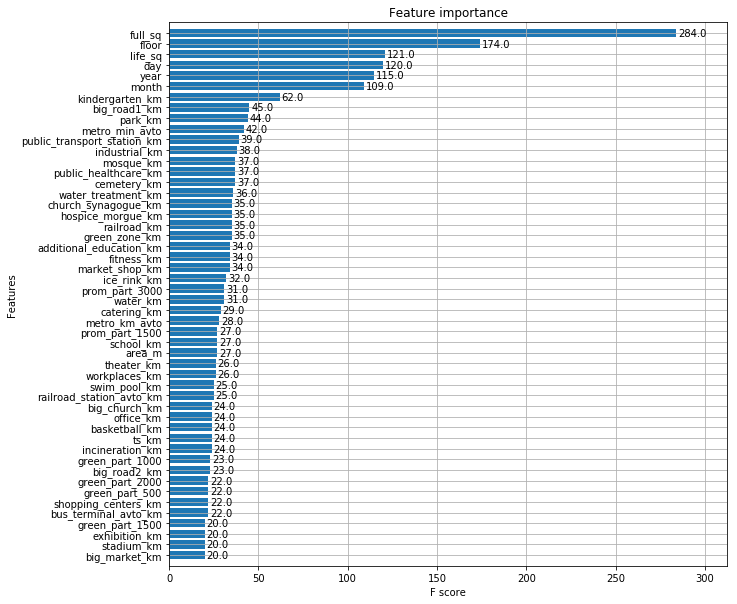

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgbr,max_num_features=50, height=0.8, ax=ax)
plt.show()

In [38]:
log_forecast = scaler2.inverse_transform(ypred)
forecast = np.exp(log_forecast)
df_train['log_forecast']=df_train['log_price']
df_train['log_forecast'][-50:] = log_forecast 
df_train['forecast']=df_train['price_doc']
df_train['forecast'][-50:] = forecast
df_train.tail()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,full_sq,life_sq,floor,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,...,ecology_excellent,ecology_good,ecology_poor,ecology_satisfactory,log_price,year,month,day,log_forecast,forecast
id,,,,,,,,,,,,,,,,,,,,,
30108,53.0000,1.0000,1.0000,"35,747,947.9100","2,546.0000",0.5490,0.0347,175.0000,"2,854.0000",0.0000,...,0,0,1,0,15.2507,2015,6,3,15.1038,"3,626,452.5000"
30109,64.0000,30.0000,5.0000,"25,536,296.8100","4,001.0000",0.4963,0.0071,275.0000,"2,854.0000",0.0000,...,0,0,1,0,15.9887,2015,6,3,15.8306,"7,501,182.0000"
30110,46.0000,46.0000,4.0000,"40,366,999.5100","21,819.0000",0.4928,0.0758,"1,497.0000","2,854.0000",0.0000,...,0,0,1,0,15.5794,2015,6,3,15.5846,"5,865,731.0000"
30111,54.0000,28.0000,12.0000,"8,392,316.2100","130,396.0000",0.4264,0.0022,"6,980.0000","4,523.0000",5.0000,...,0,0,0,1,16.0668,2015,6,3,15.9121,"8,138,039.0000"
30112,83.0000,30.0000,16.0000,"25,536,296.8100","4,001.0000",0.4963,0.0071,275.0000,"2,854.0000",0.0000,...,0,0,1,0,16.1737,2015,6,3,16.0135,"9,007,043.0000"


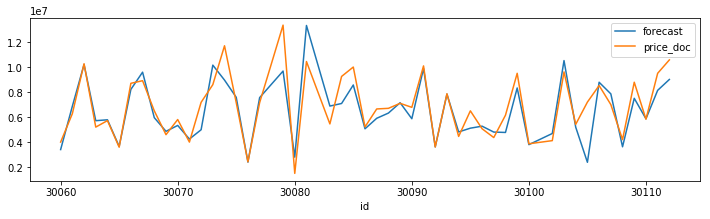

In [39]:
df_train[['forecast','price_doc']][-50:].plot(figsize=(12,3))

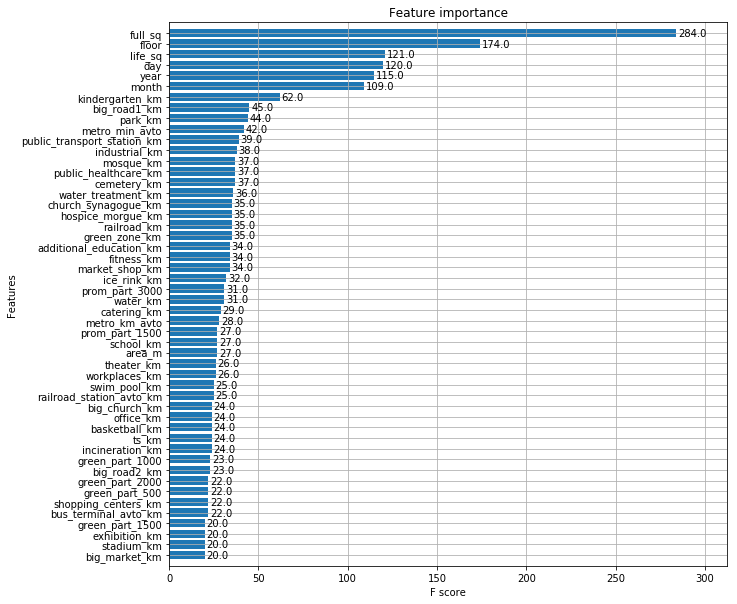

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgbr, max_num_features=50, height=0.8, ax=ax)
plt.show()

## 8.2 XGBoost - Grid Search

In [2]:
# Various hyper-parameters to tune
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(df_train.drop(['price_doc','log_price'],axis=1), df_train['log_price'])

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

()

## 8.3 XGBoost - Cross Validation

In [165]:
xgb_params = {'objective':'reg:linear','eval_metric':'mae','seed':50}

dtrain = xgb.DMatrix(x_train_s, y_train_s, feature_names=x_train_s.columns.values)
dtest = xgb.DMatrix(x_test_s)

[19:28:54] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:54] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:54] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


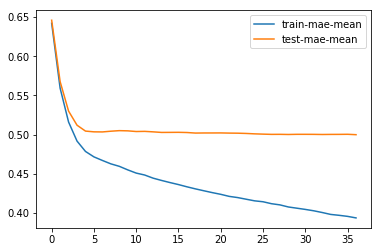

In [166]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-mae-mean', 'test-mae-mean']].plot()

## 9. ad hoc

C:\Users\rapha\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


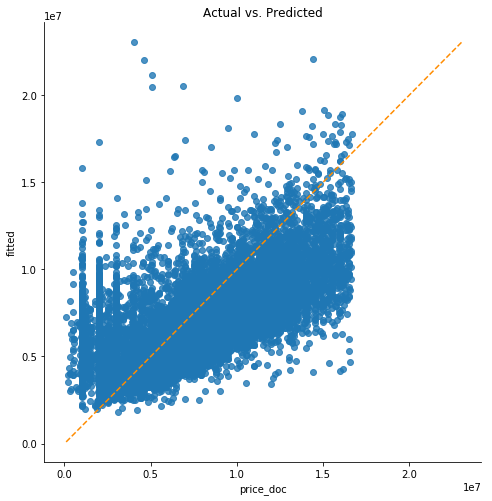

In [201]:
## 1. linear assumption
sns.lmplot(x='price_doc', y='fitted', data=df_linear, fit_reg=False, size=7)
line_coords = np.arange(df_linear[['price_doc','fitted']].min().min(), df_linear[['price_doc','fitted']].max().max())
plt.plot(line_coords, line_coords,  # X and y points
        color='darkorange', linestyle='--')
plt.title('Actual vs. Predicted')
plt.show()

In [204]:
## 2. normality of error terms
from statsmodels.stats.diagnostic import normal_ad
p_value = normal_ad(df_linear['res'])[1]
p_value

0.0

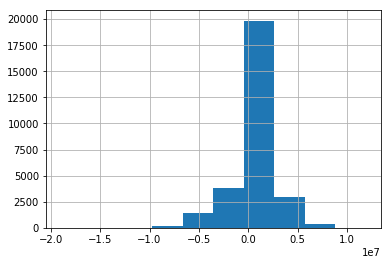

In [205]:
df_linear['res'].hist()

In [ ]:
## Shapiro-Wilk Test
from scipy.stats import shapiro
stat, p = shapiro(df_linear['res'])
p

In [ ]:
## 3. no autocorrelation in error terms (<1.5: positive auto correlation, >2.5: negative auto correlation)
from statsmodels.stats.stattools import durbin_watson
durbinWatson = durbin_watson(df_linear['res'])
durbinWatson

In [ ]:
## 4. Homoscedasticity
plt.subplots(figsize=(12, 6))
ax = plt.subplot(111)  # To remove spines
plt.scatter(x=df_linear.index, y=df_linear.res, alpha=0.5)
plt.plot(np.repeat(0, df_linear.index.max()), color='darkorange', linestyle='--')
ax.spines['right'].set_visible(False)  # Removing the right spine
ax.spines['top'].set_visible(False)  # Removing the top spine

In [ ]:
## 5. multicollearnity
plt.figure(figsize = (10,8))
sns.heatmap(pd.DataFrame(x_train_s).corr(), annot=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF = [variance_inflation_factor(x_train_s.values, i) for i in range(x_train_s.shape[1])]
VIF